# Школа глубокого обучения

<a href="https://mipt.ru/science/labs/laboratoriya-neyronnykh-sistem-i-glubokogo-obucheniya/"><img align="right" src="https://avatars1.githubusercontent.com/u/29918795?v=4&s=200" alt="DeepHackLab" style="position:relative;top:-40px;right:10px;height:100px;" /></a>



### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)

## Домашнее задание 2
*Щелчков Дмитрий (@demikandr в telegram) *
### Классификация лиц методом ближайших соседей 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

В этом задании вы обучите очень простую модель для распознавания лиц. С точки зрения машинного обучения это будет задача многоклассовой классификации -- для каждого объекта надо определить к какому классу он принадлежит (чье лицо на фотографии). В качестве метрики качества будем использовать accuracy - долю верно опознанных лиц (верно определенных классов).

В процессе вам потребуется ответить на несколько вопросов и заполнить отчет о проведенных экспериментах. Отчет должен содержать описание того, что вы сделали, и результаты, которые вы получили. Пример: "Я начинал делать домашку за 10,7, 5, 3, 1 и -1 день от дедлайна. Я обнаружил, что максимальная оценка достигается, если начинать делать домашку хотя бы за 5 дней до дедлайна."

### Загрузим данные

In [5]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

# data - это словарь из четырех матриц: train_faces, train_labels, test_faces, test_labels
#
# Каждый столбец матрицы train_faces является транспонированной картинкой преобразованной
# в одномерный столбец. Получим из этого массив картинок.
# 
# Каждый элемент массива train_labels - это номер класса соответствующего изображения, где
# классы пронумернованы от 1 до 40. Как правило, удобнее нумеровать классы начиная с нуля.

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0))
y_train = (data['train_labels'] - 1).reshape((-1,))
X_test = # Ваш код здесь
y_test = # Ваш код здесь

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

SyntaxError: invalid syntax (<ipython-input-5-3c54ee947af9>, line 17)

Посмотрим на лица.

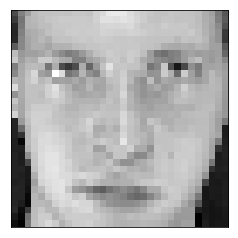

In [6]:
plt.figure()
plt.imshow(X_train[0], cmap=plt.cm.gray)
plt.xticks(()) # Удаляет метки на оси Ox
plt.yticks(()) # Удаляет метки на оси Oy
plt.show()

Чтобы не выводить лица каждый раз голыми руками напишем вспомогательную функцию.

In [7]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Вспомогательная функция для отрисовки лиц"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

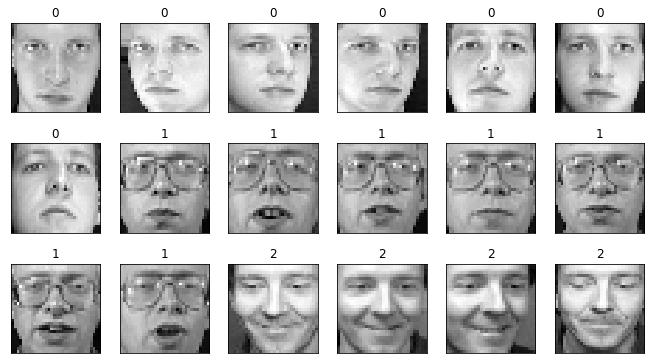

In [8]:
titles = [str(y) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Привыкаем к пространствам большой размерности

Точка/вектор (это два эквивалентных термина) в N-мерном пространстве - это набор из N чисел. Так (1, 2, 0.3, -4, 0) - это вектор пятимерного пространства.

Как правило расстояние между точками X и Y равно $\sqrt{\sum_i (x_i - y_i)^2}$.

Легко заметить, что в двухмерном случае мы получаем знакомую вам из геометрии точку и расстояние между точками. Вектора можно поэлементно складывать и вычитать -- точно так же как в двухмерном случае. Если вы изучаете какой-то алгоритм аппелирующий к геометрии, то можете представлять себе все происходящее в 2-х/3-х мерном случае, а потом говорить "в N-мерном случае всё будет аналогично". Все так делают.

## К ближайших соседей (K nearest neighbors)

Идея алгоритмов "ближайших соседей" проста - если понятие расстояния между примерами введена достаточно удачно (это может быть евклидово расстнояние между точками, определенное выше, угол между векторами, итд), то близкие в смысле этого расстояния примеры чаще лежат в одном классе, чем в разных. Классификация каждого объекта происходит следующим образом:

1) Вычисляется расстояние до каждого из объектов обучающей выборки

2) Отобраются k объектов обучающей выборки, расстояние до которых минимально

3) Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди k ближайших соседей

Например, объект на рисунке ниже будет отнесен к оранжевому классу.

<img src="files/screenshot.gif">

Посмотрим на результат применения KNN к искуственно сгенерированной выборке.

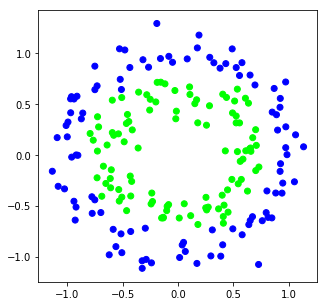

In [9]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=200, noise=0.1, factor=0.6)

plt.figure(figsize=(5, 5))
plt.scatter(*X.T, c=y, cmap=plt.cm.brg)
plt.show()

Мы воспользуемся готовой реализацией классификатора KNN из библиотеки sklearn, которая содержит множество различных алгоритмов машинного обучения и метрик.

Mean accuracy:  0.99


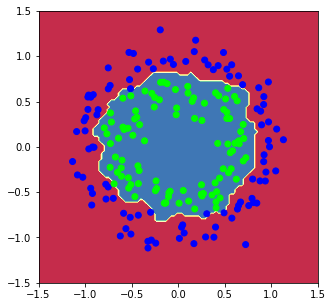

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

print('Mean accuracy: ', knn.score(X, y)) # accuracy - это процент правильно классифицированных объектов.

xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(5, 5))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(*X.T, c=y, cmap=plt.cm.brg)
plt.show()

### Вопрос: даст ли линейная регрессия хороший результат на сгенерированных выше данных? Почему?

*Ответ:*

### Вопрос: в каких случаях KNN будет работать плохо?

*Ответ:*

____________________________________________________________________________________________________________

### Применим KNN к нашей задаче

В данной задаче объектами будут лица, а их признаками - вектор пикселей. Будем использовать обычную евклидову метрику: расстояние между изображениями $X$ и $Y$ равно $\sqrt{\sum_{i,j} (X_{i,j}-Y_{i,j})^2}$.

Обучите KNN с дефолтными параметрами и посчитайте процент правильно распознанных лиц на тестовой выборке.

In [85]:
X_train_matrix = X_train.reshape((-1, image_h * image_w))

# Ваш код здесь

print('Test score: {}'.format(test_score))

Test score: 0.5


Поэкспериментируйте и опишите свои результаты. 
Идеи для дальнейших экспериментов:

1) Попробуйте найти оптимальный параметр количества ближайших соседей.

2) Посмотрите вляет ли разрешение изображения на качество классификации. Для изменения разрешения изображения можно воспользоваться функцией scipy.misc.imresize.

3*) Проведите те же самые эксперименты для линейной регрессии. Работает ли это лучше/хуже KNN? Почему?

In [89]:
# Ваш код здесь

### Отчет:
